Action for Agent 0 from problem solver
Action for Agent 1 from problem solver
win situation in the environment: [False, False]
state agent 0 before update: (0, 0)
win state agent 0 before update: False
action agent 0 before update: 4
reward agent 0 before update: -1
next state agent 0 before update: (1, 0)
agent0 not hit !!!!!
state agent 1 before update: (4, 0)
win state agent 1 before update: False
action agent 1 before update: 2
reward agent 1 before update: -1
next state agent 1 before update: (4, 1)
agent1 not hit !!!!!
Action for Agent 0 from problem solver
Action for Agent 1 from problem solver
win situation in the environment: [False, False]
state agent 0 before update: (1, 0)
win state agent 0 before update: False
action agent 0 before update: 3
reward agent 0 before update: -1
next state agent 0 before update: (0, 0)
agent0 not hit !!!!!
state agent 1 before update: (4, 1)
win state agent 1 before update: False
action agent 1 before update: 1
reward agent 1 before update: -1


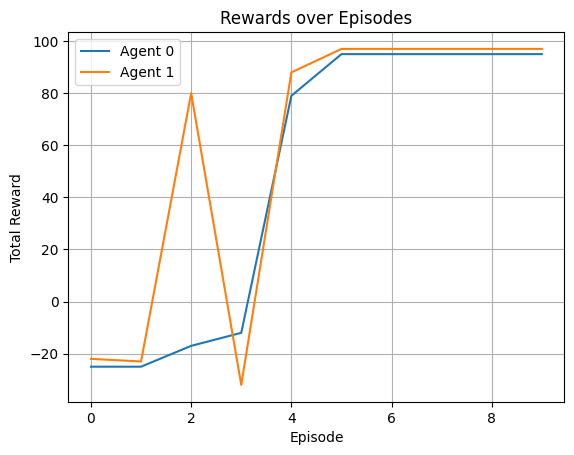

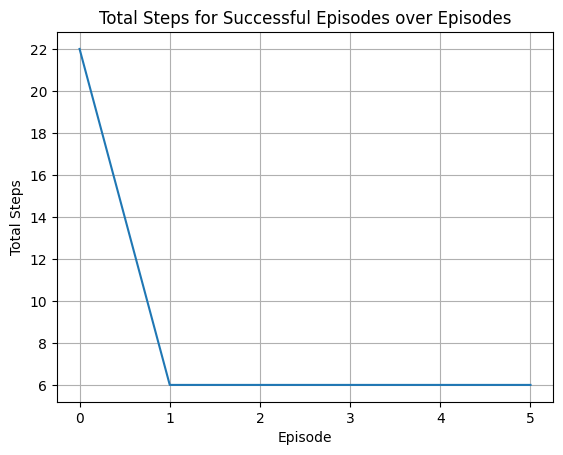

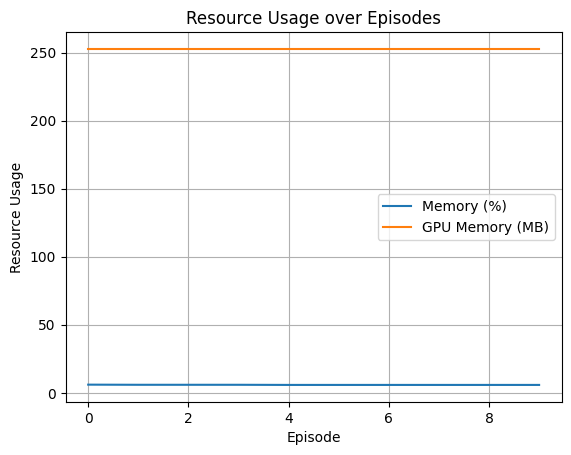

In [1]:
import numpy as np
import random
from collections import defaultdict
import ast
import json
import psutil
import pynvml
import matplotlib.pyplot as plt

from environment_ma_reward_distance_dynamic import Env

class ProblemSolver:
    def __init__(self, num_actions, env, alpha, gamma, epsilon):
        self.env = env
        self.num_actions = num_actions
        self.learning_rate = alpha
        self.discount_factor = gamma
        self.epsilon = epsilon
        self.q_tables = [defaultdict(lambda: [0.0] * num_actions) for _ in range(env.num_agents)]

    @staticmethod
    def arg_max(state_action):
        max_index_list = []
        max_value = state_action[0]
        for index, value in enumerate(state_action):
            if value > max_value:
                max_index_list.clear()
                max_value = value
                max_index_list.append(index)
            elif value == max_value:
                max_index_list.append(index)
        return random.choice(max_index_list)

    def choose_action(self, agent_idx, state):
        state = tuple(state)
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            state_action = self.q_tables[agent_idx][state]
            action = self.arg_max(state_action)
        return action

    def learn(self, agent_idx, state, action, reward, next_state):
        state = tuple(state)
        next_state = tuple(next_state)
        current_q = self.q_tables[agent_idx][state][action]
        max_next_q = max(self.q_tables[agent_idx][next_state])
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_tables[agent_idx][state][action] = new_q


class Case:
    added_states = set()  # Store states already added to the case base

    def __init__(self, problem, solution, trust_value=1):
        self.problem = ast.literal_eval(problem) if isinstance(problem, str) else problem
        self.solution = solution
        self.trust_value = trust_value
    
    @staticmethod
    def sim_q(state1, state2):
        state1 = np.atleast_1d(state1)
        state2 = np.atleast_1d(state2)
        CNDMaxDist = 6
        v = state1.size
        DistQ = np.sum([Case.dist_q(Objic, Objip) for Objic, Objip in zip(state1, state2)])
        similarity = (CNDMaxDist * v - DistQ) / (CNDMaxDist * v)
        return similarity

    @staticmethod
    def dist_q(X1, X2):
        return np.min(np.abs(X1 - X2))

    @staticmethod
    def retrieve(state, case_base, threshold=0.1):
        state = ast.literal_eval(state) if isinstance(state, str) else state
        similarities = {case: Case.sim_q(np.array(state), np.array(case.problem, dtype=float)) for case in case_base}
        sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
        return sorted_similarities[0][0] if sorted_similarities and sorted_similarities[0][1] >= threshold else None

    @staticmethod
    def reuse(c, temporary_case_base):
        temporary_case_base.append(c)

    @staticmethod
    def revise(case_base, temporary_case_base, successful_episodes):
        for case in temporary_case_base:
            if successful_episodes and case in case_base:
                case.trust_value += 0.1
            elif not successful_episodes and case in case_base:
                case.trust_value -= 0.1
            case.trust_value = max(0, min(case.trust_value, 1))

    @staticmethod
    def retain(case_base, temporary_case_base, successful_episodes, threshold=0.7):
        if successful_episodes:
            for case in reversed(temporary_case_base):
                state = tuple(np.atleast_1d(case.problem))
                if state not in Case.added_states:
                    case_base.append(case)
                    Case.added_states.add(state)
                else:
                    existing_index = next((i for i, c in enumerate(case_base) if tuple(np.atleast_1d(c.problem)) == state), None)
                    if existing_index is not None:
                        existing_case = case_base[existing_index]
                        existing_case.trust_value = case.trust_value

        case_base[:] = [case for case in case_base if case.trust_value >= threshold]
        return case_base



class QCBRL:
    def __init__(self, num_actions, env, episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min, render):
        # self.num_states = num_states
        self.num_actions = num_actions
        self.env = env
        self.episodes = episodes
        self.max_steps = max_steps
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.render = render
        self.epsilon_decay = epsilon_decay  
        self.epsilon_min = epsilon_min  

        self.problem_solvers = [ProblemSolver(num_actions, self.env, alpha, gamma, epsilon) for _ in range(self.env.num_agents)]
        self.case_bases = [[] for _ in range(self.env.num_agents)]
        self.temporary_case_bases = [[] for _ in range(self.env.num_agents)]
        self.successful_episodes = [0] * self.env.num_agents
        self.rewards_per_episode = [[] for _ in range(self.env.num_agents)]  
        self.total_successful_episodes = 0 

    def run(self):
        rewards = []
        memory_usage = []
        gpu_memory_usage = []
        num_successful_episodes = 0
        total_steps_list = []
        success_steps = []

        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)

        for episode in range(episodes):
            states = self.env.reset()
            episode_reward = [0] * self.env.num_agents
            total_steps = 0 
            self.temporary_case_bases = [[] for _ in range(self.env.num_agents)]
            success_count = [0] * self.env.num_agents
            dones = [False] * self.env.num_agents
            win_states = [False] * self.env.num_agents
            successful_episodes = False

             # while not(any(dones) or all(win_states)) and total_steps < self.max_steps:
            while not(all(dones)):
                
                actions = []
                for agent_idx in range(self.env.num_agents):
                    state = states[agent_idx]
                    # print(f"state before take action: {state}")
                    action = self.take_action(agent_idx, state)
                    actions.append(action)

                # print(f"actions pass to the environment")
                next_states, rewards, dones = self.env.step(actions)

                win_states = []
                for agent_idx in range(self.env.num_agents):
                    state = states[agent_idx]
                    action = actions[agent_idx]
                    reward = rewards[agent_idx]
                    next_state = next_states[agent_idx]

                    physical_state = tuple(state[0])
                    win_state = state[1]
                    comm_state = state[2]

                    physical_next_state = tuple(next_state[0])
                    win_next_state = next_state[1]
                    comm_next_state = next_state[2]

                    physical_action = action[0]
                    comm_action = action[1]

                    print(f"state agent {agent_idx} before update: {physical_state}")
                    print(f"win state agent {agent_idx} before update: {win_next_state}")
                    print(f"action agent {agent_idx} before update: {physical_action}")
                    print(f"reward agent {agent_idx} before update: {reward}")
                    print(f"next state agent {agent_idx} before update: {physical_next_state}")

                    c = Case(physical_state, physical_action)
                    Case.reuse(c, self.temporary_case_bases[agent_idx])

                    self.problem_solvers[agent_idx].learn(agent_idx, physical_state, physical_action, reward, physical_next_state)

                    if (win_next_state): 
                        success_count[agent_idx] += 1
                        print(f"agent{agent_idx} hit !!!!!")
                    else:
                        print(f"agent{agent_idx} not hit !!!!!")

                    episode_reward[agent_idx] += reward
                    win_states.append(win_next_state)  

                states = next_states
                total_steps += 1

                self.env.render()
                
            print(f"win states situation: {self.env.win_flag}")
            if self.env.win_flag:
                self.total_successful_episodes += 1
                success_steps.append(total_steps)
                successful_episodes = True
                

            print(f"Episode: {episode}, Total Steps: {total_steps}, Total Rewards: {episode_reward}, Status Episode: {successful_episodes}")
            print("--------------------")

            for agent_idx in range(self.env.num_agents):
                self.rewards_per_episode[agent_idx].append(episode_reward[agent_idx])
                Case.revise(self.case_bases[agent_idx], self.temporary_case_bases[agent_idx], successful_episodes)
                self.case_bases[agent_idx] = Case.retain(self.case_bases[agent_idx], self.temporary_case_bases[agent_idx], successful_episodes)
            
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
            
            memory_usage.append(psutil.virtual_memory().percent)
            gpu_memory_usage.append(pynvml.nvmlDeviceGetMemoryInfo(handle).used / 1024**2)

        self.save_case_base_temporary()  # Save temporary case base after training
        self.save_case_base()  # Save case base after training

        success_rate = self.total_successful_episodes / episodes * 100


        return self.rewards_per_episode, success_rate, memory_usage, gpu_memory_usage, success_steps

    def take_action(self, agent_idx, state):
        # print(f"state detected in take action function: {state}")
        physical_state = tuple(state[0])
        win_state = state[1]
        comm_state = state[2]

        similar_solution = Case.retrieve(physical_state, self.case_bases[agent_idx])
        if similar_solution is not None:
            physical_action = similar_solution.solution
            print(f"Action for Agent {agent_idx} from case base")
        else:
            physical_action = self.problem_solvers[agent_idx].choose_action(agent_idx, physical_state)
            print(f"Action for Agent {agent_idx} from problem solver")

        if self.env.is_agent_silent:
            communication_action = None
        else:
            if similar_solution is not None:
                communication_action = f"Message send from agent {agent_idx}"
            else:
                communication_action = None
        
        # print(f"physical action returned from the take action: {physical_action}")
        # print(f"comm action returned from the take action: {communication_action}")

        return (physical_action, communication_action)
        
    
    def save_case_base_temporary(self):
        for agent_idx in range(self.env.num_agents):
            filename = f"cases/case_base_temporary_agent_{agent_idx}.json"
            case_base_data = [{"problem": case.problem.tolist() if isinstance(case.problem, np.ndarray) else case.problem, 
                            "solution": int(case.solution), 
                            "trust_value": int(case.trust_value)} for case in self.temporary_case_bases[agent_idx]]
            with open(filename, 'w') as file:
                json.dump(case_base_data, file)
            print(f"Temporary case base for Agent {agent_idx} saved successfully.")

    def save_case_base(self):
        for agent_idx in range(self.env.num_agents):
            filename = f"cases/case_base_agent_{agent_idx}.json"
            case_base_data = [{"problem": case.problem.tolist() if isinstance(case.problem, np.ndarray) else case.problem, 
                            "solution": int(case.solution), 
                            "trust_value": int(case.trust_value)} for case in self.case_bases[agent_idx]]
            with open(filename, 'w') as file:
                json.dump(case_base_data, file)
            print(f"Case base for Agent {agent_idx} saved successfully.")
        
    def load_case_base(self):
        for agent_idx in range(self.env.num_agents):
            filename = f"cases/case_base_agent_{agent_idx}.json"
            try:
                with open(filename, 'r') as file:
                    case_base_data = json.load(file)
                    self.case_bases[agent_idx] = [Case(np.array(case["problem"]), case["solution"], case["trust_value"]) for case in case_base_data]
                    print(f"Case base for Agent {agent_idx} loaded successfully.")
            except FileNotFoundError:
                print(f"Case base file for Agent {agent_idx} not found. Starting with an empty case base.")

    def display_success_rate(self, success_rate):
        print(f"Success rate: {success_rate}%")


    def plot_rewards(self, rewards):
        # print(f"total rewards obtained: {rewards}")
        for agent_idx in range(self.env.num_agents):
            plt.plot([reward for reward in rewards[agent_idx]], label=f'Agent {agent_idx}')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Rewards over Episodes')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_total_steps(self, total_steps_list):
        plt.plot(total_steps_list)
        plt.xlabel('Episode')
        plt.ylabel('Total Steps')
        plt.title('Total Steps for Successful Episodes over Episodes')
        plt.grid(True)
        plt.show()

    def plot_resources(self, memory_usage, gpu_memory_usage):
        plt.plot(memory_usage, label='Memory (%)')
        plt.plot(gpu_memory_usage, label='GPU Memory (MB)')
        plt.xlabel('Episode')
        plt.ylabel('Resource Usage')
        plt.title('Resource Usage over Episodes')
        plt.legend()
        plt.grid(True)
        plt.show()


if __name__ == "__main__":
    num_agents = 2
    is_agent_silent = False
    episodes=30
    max_steps=1000
    alpha=0.1
    gamma=0.9
    epsilon=0.1
    epsilon_decay = 0.995  
    epsilon_min = 0.01  
    render = True

    env = Env(num_agents=num_agents, is_agent_silent=is_agent_silent)
    
    # num_states = len(env.reset())
    num_actions = len(env.action_space)
    
    agent = QCBRL(num_actions, env, episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min, render)
    rewards, success_rate, memory_usage, gpu_memory_usage, total_step_list = agent.run()

    agent.display_success_rate(success_rate)
    agent.plot_rewards(rewards)
    agent.plot_total_steps(total_step_list)
    agent.plot_resources(memory_usage, gpu_memory_usage)
